In [1]:
from jax import numpy as jnp
from jax import jacfwd, jacrev, jit, vmap, lax, make_jaxpr
from jax import random as jr
from jax import tree_util as jtu
from functools import partial

import gaussfiltax.utils as utils
import gaussfiltax.containers as containers
from dynamax.nonlinear_gaussian_ssm.models import ParamsNLGSSM, NonlinearGaussianSSM
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import time
import gaussfiltax.inference as gf

import matplotlib.pyplot as plt

In [9]:
# Parameters
state_dim = 1
emission_dim = 1
seq_length = 100
mu0 = jnp.zeros(state_dim)
Sigma0 = 1.0 * jnp.eye(state_dim)
Q = 1.0 * jnp.eye(state_dim)
R = 1.0 * jnp.eye(emission_dim)

# Nonlinearities
f1 = lambda x: jnp.sin(10 * x)
g1 = lambda x: 0.1 * jnp.array([jnp.dot(x, x)])

f2 = lambda x: 0.8 * x
def g2(x):
    return 2 * x
#    return jnp.array([[1, 0], [0, 1], [0, 0]]) @ x

# stochastic growth model
f3 = lambda x, u: x / 2. + 25. * x / (1+ jnp.power(x, 2)) + u
g3 = lambda x, u: x**2/20.

# Inputs
inputs = 8. * jnp.cos(jnp.arange(seq_length))

In [10]:
# Model definition 
model = NonlinearGaussianSSM(state_dim, emission_dim)
params = ParamsNLGSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f3,
    dynamics_covariance=Q,
    emission_function=g3,
    emission_covariance=R,
)

# Generate synthetic data 
key = jr.PRNGKey(0)
states, emissions = model.sample(params, key, seq_length, inputs = inputs)

# Run inference
num_components = [5, 3, 3] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check containers._branch_from_node
posterior_filtered, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, opt_args = (20, 0.001, 50), inputs=inputs)

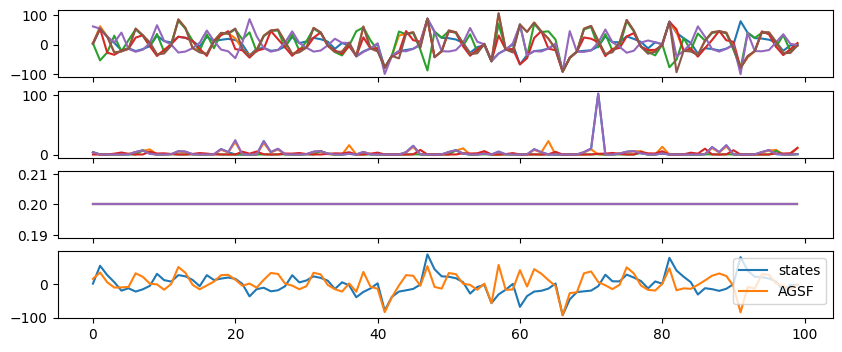

In [11]:
num_components = 5

point_estimates = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered.means, posterior_filtered.weights), axis=0)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 4))
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(num_components):
    axes[0].plot(posterior_filtered.means[m])
    leg.append("model {}".format(m))
#axes[0].legend(leg)

for m in range(num_components):
    axes[1].plot(posterior_filtered.covariances[m].squeeze())

for m in range(num_components):
    axes[2].plot(posterior_filtered.weights[m])

axes[3].plot(states, label="xs")
leg = ["states", "AGSF"]
axes[3].plot(point_estimates)
axes[3].legend(leg)
plt.show()

In [ ]:
aux_outputs['Deltas']
# posterior_filtered.covariances